In [1]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("asdasdasasdas/garbage-classification")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/garbage-classification


In [3]:
data_dir  = '/kaggle/input/garbage-classification/Garbage classification/Garbage classification'

classes = os.listdir(data_dir)
print(classes)

['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']


In [4]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: trash (Class No: 5)


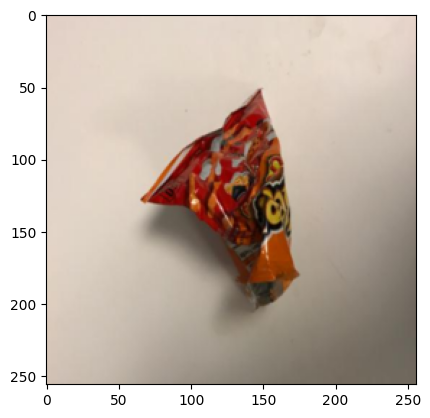

In [6]:
img, label = dataset[2500]
show_sample(img, label)

In [7]:
torch.manual_seed(42)

In [8]:
type(dataset)

torchvision.datasets.folder.ImageFolder

In [9]:
train_ds, val_ds, test_ds = random_split(dataset, [1593, 176, 758])
len(train_ds), len(val_ds), len(test_ds)

(1593, 176, 758)

In [10]:
type(train_ds)

torch.utils.data.dataset.Subset

In [11]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [12]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [13]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

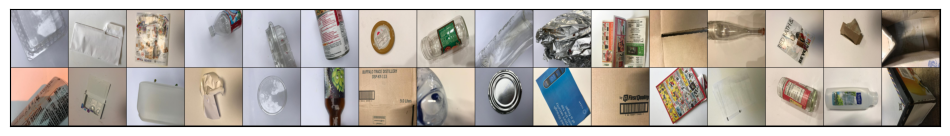

In [14]:
show_batch(train_dl)

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [16]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))

    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 170MB/s]


In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:
device = get_default_device()
device

device(type='cuda')

In [19]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [20]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
model = to_device(ResNet(), device)

In [22]:
evaluate(model, val_dl)

{'val_loss': 1.8004014492034912, 'val_acc': 0.1302083283662796}

In [23]:
num_epochs = 8
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.4670, val_loss: 1.2819, val_acc: 0.8160
Epoch 2: train_loss: 1.1890, val_loss: 1.1700, val_acc: 0.9132
Epoch 3: train_loss: 1.0946, val_loss: 1.1382, val_acc: 0.9201
Epoch 4: train_loss: 1.0732, val_loss: 1.1264, val_acc: 0.9514
Epoch 5: train_loss: 1.0642, val_loss: 1.1372, val_acc: 0.9201
Epoch 6: train_loss: 1.0616, val_loss: 1.1215, val_acc: 0.9410
Epoch 7: train_loss: 1.0584, val_loss: 1.1062, val_acc: 0.9479
Epoch 8: train_loss: 1.0544, val_loss: 1.1056, val_acc: 0.9531


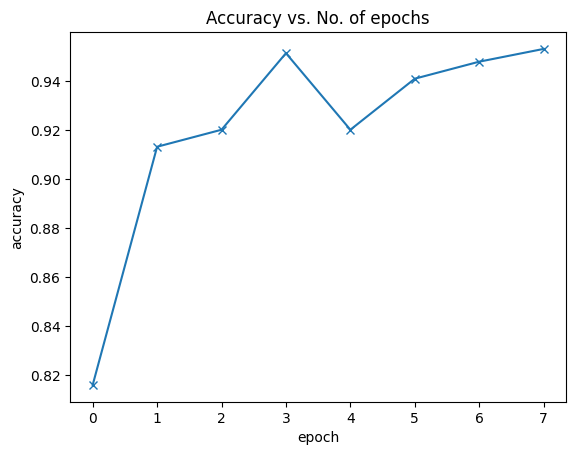

In [24]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

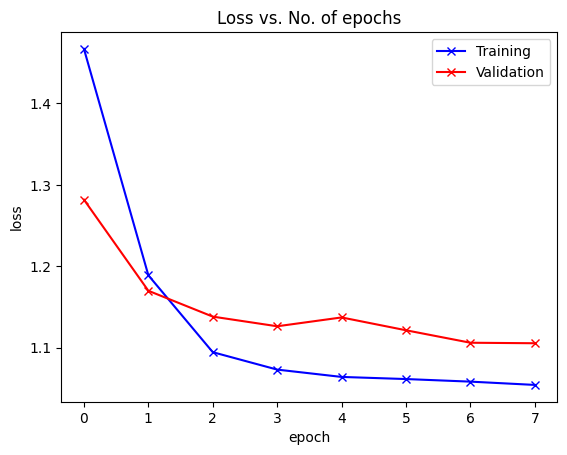

In [25]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [26]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: plastic , Predicted: plastic


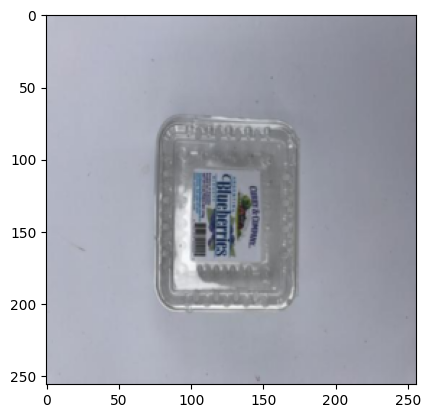

In [30]:
img, label = test_ds[400]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: glass , Predicted: glass


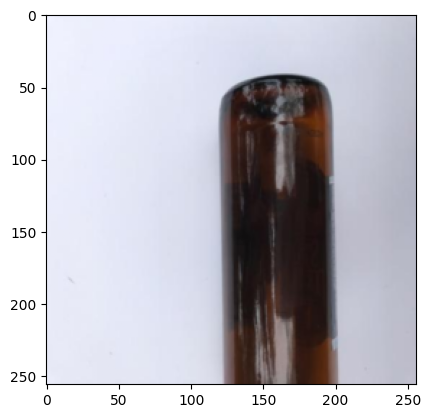

In [31]:
img, label = test_ds[23]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: plastic , Predicted: plastic


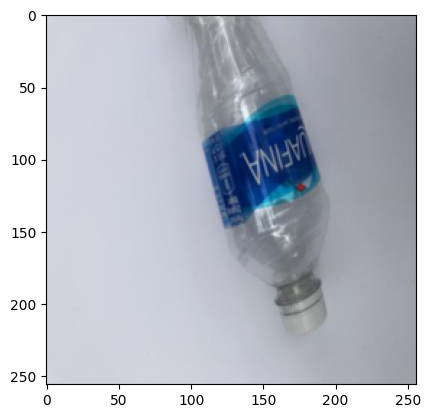

In [32]:
img, label = test_ds[51]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [33]:
import urllib.request
urllib.request.urlretrieve("https://images.unsplash.com/photo-1616118132534-381148898bb4?auto=format&fit=crop&q=80&w=1000&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8Mnx8cGxhc3RpYyUyMGJvdHRsZXxlbnwwfHwwfHx8MA%3D%3D", "1.jpg")
urllib.request.urlretrieve("https://www.wastemanaged.co.uk/wp-content/uploads/2023/02/Blog-Images-2023-02-09T154829.921.jpg", "2.jpg")
urllib.request.urlretrieve("https://media.istockphoto.com/id/950590270/th/%E0%B8%A3%E0%B8%B9%E0%B8%9B%E0%B8%96%E0%B9%88%E0%B8%B2%E0%B8%A2/%E0%B9%81%E0%B8%9C%E0%B9%88%E0%B8%99%E0%B8%AD%E0%B8%B1%E0%B8%94%E0%B8%97%E0%B8%B5%E0%B9%88%E0%B9%81%E0%B8%A2%E0%B8%81%E0%B9%84%E0%B8%94%E0%B9%89%E0%B8%9A%E0%B8%99%E0%B8%9E%E0%B8%B7%E0%B9%89%E0%B8%99%E0%B8%AB%E0%B8%A5%E0%B8%B1%E0%B8%87%E0%B8%AA%E0%B8%B5%E0%B8%82%E0%B8%B2%E0%B8%A7.jpg?s=612x612&w=0&k=20&c=_iwuIySAYeQsYD1xa_YHYVXUhDYUXCieYLd4mLfp3eE=", "3.jpg")
urllib.request.urlretrieve("https://3.bp.blogspot.com/-u4Grbg5nz28/WYaB1YY7KII/AAAAAAAAi3I/jSEfbT76_Iogg2k45XK8eFnaHDgRSsMBgCLcBGAs/s1600/magnum_wine_bottle.jpg", "4.jpg")
urllib.request.urlretrieve("https://www.onegreenplanet.org/wp-content/uploads/2012/10/Paper-Waste-Go-Paperless.jpeg", "5.jpg")

('5.jpg', <http.client.HTTPMessage at 0x7b705265f8d0>)

In [34]:
loaded_model = model

In [35]:
from PIL import Image
from pathlib import Path

def predict_external_image(image_name):
    image = Image.open(Path('./' + image_name))

    example_image = transformations(image)
    plt.imshow(example_image.permute(1, 2, 0))
    print("The image resembles", predict_image(example_image, loaded_model) + ".")

The image resembles plastic.


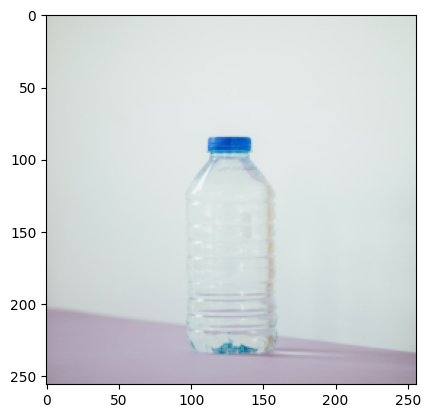

In [36]:
predict_external_image('1.jpg')

The image resembles cardboard.


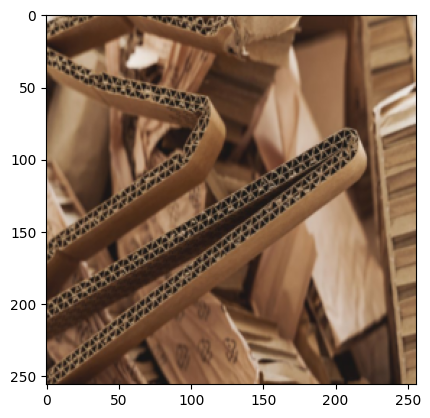

In [37]:
predict_external_image('2.jpg')

The image resembles metal.


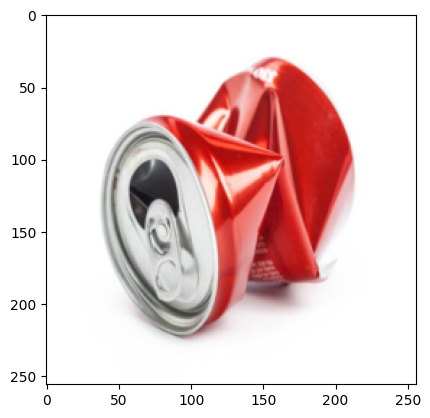

In [38]:
predict_external_image('3.jpg')

The image resembles glass.


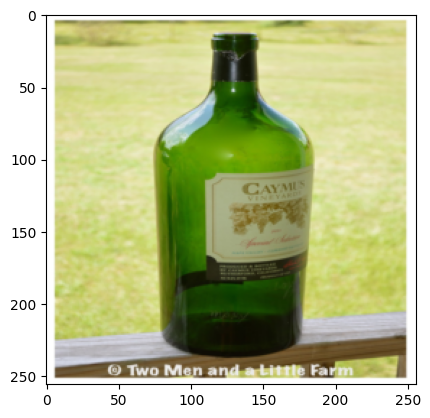

In [40]:
predict_external_image('4.jpg')

The image resembles paper.


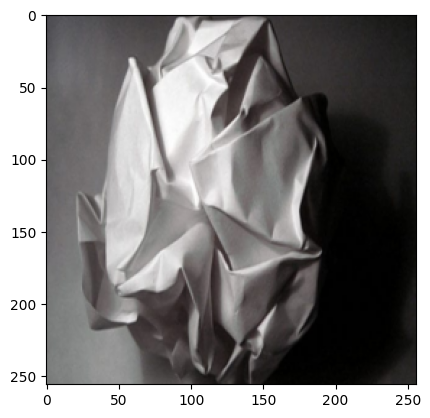

In [41]:
predict_external_image('5.jpg')

In [42]:
#save the model
torch.save(model.state_dict(), 'garbage_classification_model.pth')